The input of the NN is 1D. 

In [4]:
import numpy as np
import copy
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
from torch.nn.functional import normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

INPUT_SIZE = 1
OUTPUT_SIZE = 1

LOWER_BOUND = -6
UPPER_BOUND = 6
N_POINTS = 1001


def quad_fn(a, b, c, x):
    return a*x**2 + b*x + c

def x_square(x: torch.tensor) -> torch.Tensor:
    return x**2

# DEFINE GIVEN FUNCTION V(x): ax^2 + bx + c
given_fn = x_square

In [5]:
# CREATING DATASET:
x_values = [i for i in np.linspace(LOWER_BOUND, UPPER_BOUND, N_POINTS)]
y_values = [given_fn(i) for i in x_values]

x_train = np.array(x_values, dtype=np.float32).reshape(-1, 1)
y_train = np.array(y_values, dtype=np.float32).reshape(-1, 1)

print(x_train.shape, y_train.shape)

(1001, 1) (1001, 1)


In [6]:
# CUSTOM LOSS FUNCTION:
# def EpsilonLoss(nn.Module):

def epsilon_Loss(v_x, model_u, lower_bound, upper_bound, n_points):
    """
    GOAL: Epsilon function evaluated at u using discretized estimation
    minimizing Epsilon(u) = 
    
    ARGS: 
    n_points (int): number of discretized points on the interval [-L, L]
    e.g.: -(L)|---|---|---|---|(L) interval has n_points = 5

    v_x (torch.Tensor): function instance
    model_u (torch.Tensor): model output
    """
    sum = 0
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)

        # u_xi.backward()
        # u_prime = x_i.grad
        
        u_prime = model_u.u_prime(x_i)
        
        v_xi = v_x(x_i)
        t = torch.square(u_prime) + v_xi*(u_xi**2)
        sum += t
        # print("x_i = " + str(x_i))
        # print("u_xi = " + str(u_xi))
        # print("u_prime = " + str(u_prime))
        # print("v_xi = " + str(v_xi))
        # print(t)
        # print('-----')
    return 0.5*h*sum

# NORMALIZE MODEL u(x) OUTPUT:
def normalize_u(model_u, lower_bound, upper_bound, n_points):
    """
    Normalize model.output weight by: 
    model.output *= c
    where,
    scalar c = 1/denom
    """
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    s = 0
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        t = model_u(x_i)**2
        s += t
    denom = math.sqrt(h) * torch.sqrt(s)
    return 1/denom

In [7]:
# CREATING MODEL CLASS
class Nonlinear(nn.Module):
    def __init__(self, n):
        # One hidden layer with n nodes
        super().__init__()
        self.hidden = nn.Linear(1, n)
        self.output = nn.Linear(n, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.target_fn = given_fn

    def forward(self, x, use_tanh_fn = False, activation_on_output = False):
        if use_tanh_fn == True:
            x = self.hidden(x)
            x = self.tanh(x)
            x = self.output(x)
            
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
            
        if activation_on_output == False:
            return x
        else:
            if use_tanh_fn == True:
                return self.tanh(x)
            else:       
                return self.sigmoid(x)
        # output is a linear combination of the hidden layers because 
        # we perform regression ???
        return x

    def u_prime(self, input):
        """
        NN with 1 hidden node layer is of the form:
        u(x) = SUM_i_to_N(a_i * sigmoid(w.x + b))

        where
        a_i is the corresponding weight of self.output layerq
        w is self.hidden.weight vector
        b is self.hidden.bias vector
        sigmoid(w.x + b) is the sigmoid-activated hidden vector

        Formula of u'(x) (for 1 hidden layer NN):
        u'(x) = SUM_i_to_N(w_i*a_i*sigmoid'(w_i*x+b))
        Note: sigmoid'(w_i*x +b) = sigmoid(w_i*x+b)*(1-sigmoid(w_i*x+b))
        """
        a_i = self.output.weight.data
        w_i = torch.transpose(self.hidden.weight.data, 0, 1)
        wi_ai = w_i * a_i

        hid_layer = self.hidden(input)
        hid_layer_T = torch.reshape(hid_layer, (list(hid_layer.shape)[0], 1))
        m = hid_layer_T * (1-hid_layer_T)

        return wi_ai @ m
    
# TRANING MODEL
    def train_network(self, num_epochs, v_x, optimizer, 
                      LOWER_BOUND, UPPER_BOUND, N_POINTS):
        # For plotting loss value over epochs:
        x_epochs = [i for i in range(num_epochs)]
        y_loss = []
        for epoch in range(num_epochs):
            if epoch % batch_size == 0:
                c = normalize_u(self, LOWER_BOUND, UPPER_BOUND, N_POINTS)
                self.output.weight.data.copy_(c.item() * self.output.weight.data)
                self.output.bias.data.copy_(c.item() * self.output.bias.data)
                
#             for (x, output) in (zip(x_train, y_train)):
#                 if torch.cuda.is_available():
#                     input = Variable(torch.from_numpy(input).cuda())
#                     output = Variable(torch.from_numpy(output).cuda())
#                 else:
#                 x = Variable(torch.from_numpy(x))
#                 output = Variable(torch.from_numpy(output))

            optimizer.zero_grad()
            loss = epsilon_Loss(v_x, self, LOWER_BOUND, 
                                UPPER_BOUND, N_POINTS)
            y_loss.append(loss)
            print('epoch {}, loss {}'.format(epoch, loss.item()))
            loss.backward()
            # Calculate the derivative(loss) w.r.t the model's parameters
            adam_optimizer.step()

        return (x_epochs, y_loss)

In [34]:
# CHECK function u_prime() correctness:

t_model = Nonlinear(20)

x = torch.tensor([10], requires_grad=True, dtype=torch.float)
Q = x**2

In [35]:
t_model

Nonlinear(
  (hidden): Linear(in_features=1, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)

In [36]:
a = t_model(x)
print(a)
print(x.grad)

tensor([-0.3433], grad_fn=<AddBackward0>)
None


In [37]:
a.backward()

In [38]:
x.grad

tensor([-0.0156])

In [23]:
t_model.u_prime(x)

tensor([[-24.8482]], grad_fn=<MmBackward>)

In [18]:
loss = epsilon_Loss(given_fn, model, LOWER_BOUND, 
                                UPPER_BOUND, N_POINTS)
loss

tensor([[210.2636]], grad_fn=<MulBackward0>)

In [19]:
loss.backward()
loss

tensor([[210.2636]], grad_fn=<MulBackward0>)

In [20]:
adam_optimizer.step()

In [21]:
loss

tensor([[210.2636]], grad_fn=<MulBackward0>)

In [11]:
# DEFINE HYPER-PARAMETERS
batch_size = 70
learningRate = 0.05
num_epochs = 2000
# num_epochs = int(num_iters/(len(x_train)/batch_size))

#INIT PARAMETERS: 
# v_x = given_fn
l_b = -10
u_b = 10
n_points = 5

#INIT MODEL
model = Nonlinear(20)
if torch.cuda.is_available():
    model.cuda()

# INIT OPTIMIZER CLASS
# What is an optimizer: 
# SGD:
# SGD_optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
# Adam:
adam_optimizer = torch.optim.Adam(model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

# INIT LOSS FUNCTION: MSE
# criterion = epsilon_Loss

In [ ]:
num_epochs = 5000
graph_val = model.train_network(num_epochs, given_fn, adam_optimizer, LOWER_BOUND, UPPER_BOUND, N_POINTS)

In [79]:
epsilon_Loss(v_x, model, LOWER_BOUND, UPPER_BOUND, N_POINTS)

tensor([[345.6585]], grad_fn=<MulBackward0>)

In [45]:
new_model = copy.deepcopy(model)

In [ ]:
adam_opt = torch.optim.Adam(new_model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)
new_training = new_model.train_network(num_epochs, given_fn, adam_opt, LOWER_BOUND, UPPER_BOUND, N_POINTS)


In [41]:
id(new_hidden)

140581862395328

In [23]:
loss_val = [i.detach().numpy().item() for i in graph_val[1]]

In [ ]:
loss_val

<Figure size 432x288 with 0 Axes>

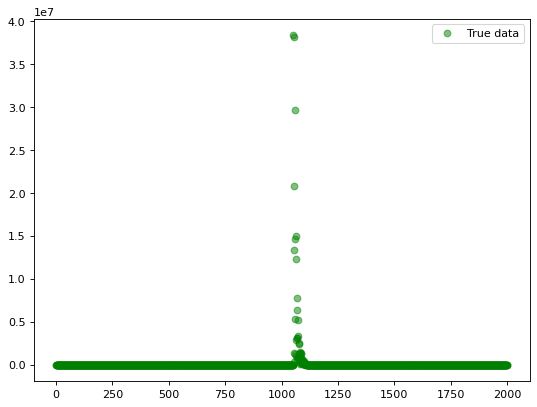

In [28]:
plot_figure(graph_val[0], loss_val)

In [25]:
v_x = given_fn
l_b = -10
u_b = 10
n_points = 200
model_u = Nonlinear(20)

res = epsilon_Loss(given_fn, model_u, l_b, u_b, n_points)
print(res)

tensor([[1325.6332]], grad_fn=<MulBackward0>)


In [26]:
add penalty 

None


In [38]:
w = model_u.output.weight.data
c = normalize_u(model_u, LOWER_BOUND, UPPER_BOUND, N_POINTS)
print(w)


tensor([[ 0.1041,  0.0962, -0.1771,  0.0874,  0.1113, -0.2226, -0.1965, -0.0349,
         -0.1274, -0.0800, -0.1009, -0.0265,  0.1447, -0.1653, -0.0199,  0.1231,
         -0.1137, -0.0332,  0.1343, -0.2128]])
tensor([[ 0.0539,  0.0498, -0.0917,  0.0452,  0.0576, -0.1152, -0.1017, -0.0180,
         -0.0659, -0.0414, -0.0522, -0.0137,  0.0749, -0.0855, -0.0103,  0.0637,
         -0.0589, -0.0172,  0.0695, -0.1101]])


In [51]:
model_u.output.weight.data.copy_(c.item() * w)
print(model_u.output.weight.data)
#= model_u.output.weight * c.item()

tensor([[ 0.0539,  0.0498, -0.0917,  0.0452,  0.0576, -0.1152, -0.1017, -0.0180,
         -0.0659, -0.0414, -0.0522, -0.0137,  0.0749, -0.0855, -0.0103,  0.0637,
         -0.0589, -0.0172,  0.0695, -0.1101]])


In [52]:
model_u.output.weight.data

tensor([[ 0.0539,  0.0498, -0.0917,  0.0452,  0.0576, -0.1152, -0.1017, -0.0180,
         -0.0659, -0.0414, -0.0522, -0.0137,  0.0749, -0.0855, -0.0103,  0.0637,
         -0.0589, -0.0172,  0.0695, -0.1101]])

In [27]:
# PLOT DATA
def plot_figure(x_train, y_train, x_test=None, predicted=None):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

<Figure size 432x288 with 0 Axes>

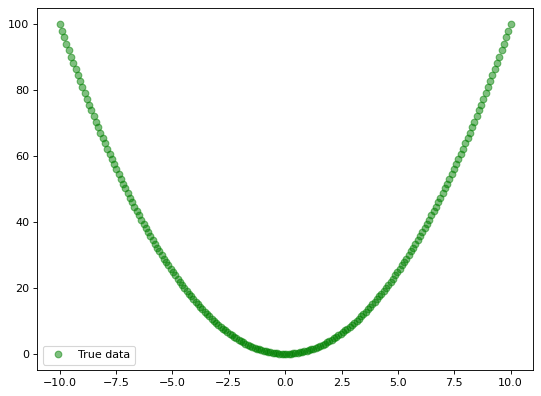

In [10]:
plot_figure(x_train, y_train)

# HOW TO TRAIN THE NN MODEL:
1. Reset adam_optimizer: 
```adam_opt.zero_grad()```
2. Calculate loss
3. Update the optimizer: 
```adam_opt.step()```


        weight = weight - lr * gradient

-> use lr and gradient to "improve" weight layer. 

Explanation:
```adam_opt.step()```: Update the model's parameters 


In [ ]:
model_p = Nonlinear_2(4)
adam_opt = torch.optim.Adam(model_p.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

In [ ]:
x_i = torch.tensor([-2.5], requires_grad=True, dtype=torch.float)
u_xi = model_p(x_i)
print(u_xi)
u_xi.backward()
u_prime = x_i.grad

tensor([-0.5799], grad_fn=<AddBackward0>)


In [ ]:
# Access the model's parameters:
# Model's hidden layer weight and bias
print("- Hidden layers: ")
print(model_p.hidden.weight)
print("\n")

print("- Hidden layers gradients (derivative of Loss w.r.t model params): ")
print(model_p.hidden.weight.grad)
print(model_p.hidden.bias)
print("\n")

# Model's output layer weight and bias
print("Output layers: ")
print(model_p.output.weight)
print(model_p.hidden.weight.grad)
print(model_p.output.bias)

# model.zero_grad()

i, o = (x_train[0], y_train[0])
i = Variable(torch.from_numpy(i))
o = Variable(torch.from_numpy(o))


- Hidden layers: 
Parameter containing:
tensor([[-0.4363],
        [-0.2556],
        [ 0.6323],
        [-0.8666]], requires_grad=True)


- Hidden layers gradients (derivative of Loss w.r.t model params): 
None
Parameter containing:
tensor([ 0.9463, -0.8034, -0.8181,  0.5812], requires_grad=True)


Output layers: 
Parameter containing:
tensor([[-0.3294, -0.3360,  0.0453, -0.0283]], requires_grad=True)
None
Parameter containing:
tensor([0.4850], requires_grad=True)


In [ ]:
import copy

model_pp = copy.deepcopy(model_p)
print(model_pp.hidden)
loss = epsilon_Loss(given_fn, model_pp, LOWER_BOUND, UPPER_BOUND, N_POINTS)
loss.backward()

Linear(in_features=1, out_features=4, bias=True)


RuntimeError: ignored

In [ ]:
model_pp.hidden.weight.grad

In [ ]:
loss.backward()

RuntimeError: ignored

In [ ]:
print("- Hidden layers: ")
print(model_p.hidden.weight)
print("\n")

print("- Hidden layers gradients (derivative of Loss w.r.t model params): ")
print(model_p.hidden.weight.grad)
print(model_p.hidden.bias)
print("\n")

# Model's output layer weight and bias
print("Output layers: ")
print(model_p.output.weight)
print(model_p.hidden.weight.grad)
print(model_p.output.bias)

# model.zero_grad()

i, o = (x_train[0], y_train[0])
i = Variable(torch.from_numpy(i))
o = Variable(torch.from_numpy(o))

- Hidden layers: 
Parameter containing:
tensor([[-0.4363],
        [-0.2556],
        [ 0.6323],
        [-0.8666]], requires_grad=True)


- Hidden layers gradients (derivative of Loss w.r.t model params): 
None
Parameter containing:
tensor([ 0.9463, -0.8034, -0.8181,  0.5812], requires_grad=True)


Output layers: 
Parameter containing:
tensor([[-0.3294, -0.3360,  0.0453, -0.0283]], requires_grad=True)
None
Parameter containing:
tensor([0.4850], requires_grad=True)


In [ ]:
x.grad.zero_()

tensor([0., 0., 0.])

In [ ]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

t = 3*a**3 - b**2

external_grad = torch.tensor([1., 1.])
t.backward(gradient=external_grad)

print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


https://neptune.ai/blog/pytorch-loss-functions
https://stackoverflow.com/questions/53980031/pytorch-custom-loss-function
https://stackoverflow.com/questions/65947284/loss-with-custom-backward-function-in-pytorch-exploding-loss-in-simple-mse-exa
https://www.youtube.com/watch?v=ma2KXWblllc